In [1]:
import torch
from torch import Tensor
from torch.utils.data import DataLoader
from model import GPT
from data_fetcher import (
    get_padded_image,
    get_line,
    extract_patch,
    get_line_data,
    extract_patches,
    generate_training_data,
    get_answer_triplet,
    compare_model_answer,
)
import einops
import matplotlib.pyplot as plt
from showmethetypes import SMTT
import pandas as pd

/home/thetis/.local/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/thetis/.local/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda20CUDACachingAllocator9allocatorE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
tt = SMTT("torch")

### Get Model

In [3]:
window = 10
div = 16
input_dim = window**2 * 4 * 3
model = GPT(
    num_layers=3,
    d_model=256,
    num_heads=8,
    d_hidden=2048,
    input_dim=input_dim,
).to(device="cuda")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)


def loss_fn(prediction, target):
    # row-wise MSE loss
    squared_diff = (prediction - target) ** 2
    row_wise_sum = torch.sum(squared_diff, dim=1)
    row_wise_mse = torch.mean(row_wise_sum)
    return row_wise_mse


def row_wise_loss_fn(prediction, target):
    squared_diff = (prediction - target) ** 2
    row_wise_sum = torch.sum(squared_diff, dim=1)
    return row_wise_sum

In [4]:
input_dim

1200

### Training

In [5]:
image = get_padded_image("./juneau2k.jpg", window).to("cuda")

/opt/miniconda3/lib/python3.10/site-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (122880000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [6]:
d = get_line_data(range(9), split=False)
train, test = d[], d[1]

In [7]:
tt(d)

list (10571)
    |__tuple
        |__Tensor (dtype: torch.float64)
        |   |  (device: cpu)
        |   |__dim_0 (2)
        |   |__dim_1 (2)
        |__Tensor (dtype: torch.float64)
            |  (device: cpu)
            |__dim_0 (2)


In [9]:
tt(train)

tuple
    |__Tensor (dtype: torch.float64)
    |   |  (device: cpu)
    |   |__dim_0 (2)
    |   |__dim_1 (2)
    |__Tensor (dtype: torch.float64)
        |  (device: cpu)
        |__dim_0 (2)


In [8]:
train_xs, train_ys = zip(*list(train))
train_xs = torch.stack(train_xs)
train_ys = torch.stack(train_ys)
test_xs, test_ys = zip(*list(test))
test_xs = torch.stack(test_xs)
test_ys = torch.stack(test_ys)

RuntimeError: stack expects each tensor to be equal size, but got [2] at entry 0 and [] at entry 1

In [ ]:
training_data = generate_training_data(image, train_xs, window)
testing_data = generate_training_data(image, test_xs, window)

In [ ]:
tt(training_data)

Tensor (dtype: torch.float32)
    |  (device: cuda:0)
    |__dim_0 (5768)
    |__dim_1 (2)
    |__dim_2 (1200)


### Letting the model take the reins

In [ ]:
train_losses = []
test_losses = []

In [ ]:
size = window
epochs = 450
model = model.to("cuda")
training_data = training_data.to("cuda").float()
train_ys = train_ys.to(device="cuda").float()
test_ys = test_ys.to(device="cuda").float()
for epoch in range(epochs):
    optimizer.zero_grad()
    prediction = model(training_data)[:, -1]
    loss = loss_fn(prediction, train_ys)
    with torch.no_grad():
        prediction = model(testing_data)[:, -1]
        test_loss = loss_fn(prediction, test_ys)

    train_losses.append(loss)
    test_losses.append(test_loss)
    print(f"Epoch: {epoch} | Test Loss: {loss} | Train Loss: {test_loss}")
    loss.backward()
    optimizer.step()

Epoch: 0 | Test Loss: 18.88450813293457 | Train Loss: 18.555727005004883
Epoch: 1 | Test Loss: 16.961933135986328 | Train Loss: 16.640615463256836
Epoch: 2 | Test Loss: 15.18541431427002 | Train Loss: 14.886537551879883
Epoch: 3 | Test Loss: 13.583577156066895 | Train Loss: 13.287089347839355
Epoch: 4 | Test Loss: 12.134140014648438 | Train Loss: 11.867840766906738
Epoch: 5 | Test Loss: 10.847896575927734 | Train Loss: 10.592414855957031
Epoch: 6 | Test Loss: 9.729561805725098 | Train Loss: 9.46135139465332
Epoch: 7 | Test Loss: 8.731679916381836 | Train Loss: 8.498357772827148
Epoch: 8 | Test Loss: 7.916683673858643 | Train Loss: 7.6756391525268555
Epoch: 9 | Test Loss: 7.204083442687988 | Train Loss: 6.984828948974609
Epoch: 10 | Test Loss: 6.629162311553955 | Train Loss: 6.419528007507324
Epoch: 11 | Test Loss: 6.183938503265381 | Train Loss: 5.952271938323975
Epoch: 12 | Test Loss: 5.822713375091553 | Train Loss: 5.608838081359863
Epoch: 13 | Test Loss: 5.5555009841918945 | Train L

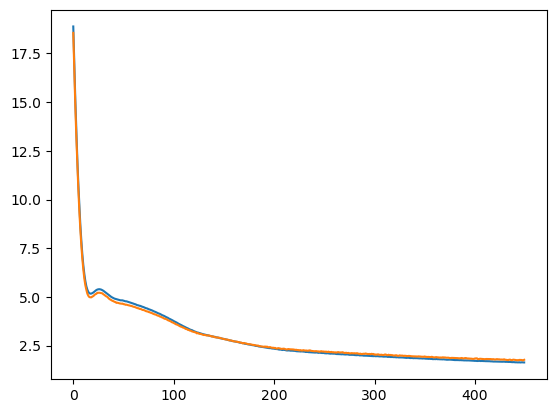

In [ ]:
def numpy(v):
    return v.detach().cpu().numpy()


plot_losses = [list(map(lambda v: numpy(v), l)) for l in [train_losses, test_losses]]
plot_losses[0][0]
plt.plot(plot_losses[0])
plt.plot(plot_losses[1])
plt.show()

In [ ]:
def lineWalk(image, model, coordinates, iters, history=None):
    if history == None:
        history = [coordinates[0]]
        # history = []
    # input for this iter
    patches = extract_patches(image, coordinates, window).unsqueeze(0)

    model_guess = model(patches)[0, -1]
    tt(model_guess)
    if (model_guess.round().int() == torch.tensor([0, 0]).to("cuda")).all():
        print("Next model jump is (0,0). Done!")
        return history
    new_coordinates = torch.stack([coordinates[-1], coordinates[-1]])
    new_coordinates[-1] += model_guess

    history.append(new_coordinates[-1])
    if iters >= 1500:
        return history
    return lineWalk(image, model, new_coordinates, iters + 1, history=history)

In [ ]:
starting_coord = get_line(1)[0:2]

In [ ]:
tt(starting_coord)

Tensor (dtype: torch.float64)
    |  (device: cpu)
    |__dim_0 (2)
    |__dim_1 (2)


In [ ]:
walk = lineWalk(image, model, starting_coord.to("cuda"), 0, history=None)
tt(walk)
walk = torch.stack(walk)
tt(walk)

TypeError: extract_patches() missing 1 required positional argument: 'size'

In [ ]:
csvable_points = torch.cat([torch.ones(walk.shape[0], 1).to("cuda") * 0, walk], dim=1)
tt(csvable_points)
df = pd.DataFrame(numpy(csvable_points), columns=["index", "x", "y"])

df.to_csv("./model_walk.csv", index=False, header=False)

Tensor (dtype: torch.float64)
    |__dim_0 (1502)
    |__dim_1 (3)
